<img src ="Images/GatorGlaciologyLogo-01.jpg" width="100" align = "right">

# Sequential Gaussian simulation
#### Gator Glaciology Lab, University of Florida

We saw in the kriging example that kriging does not reproduce the variogram statistics of the data, making it an unrealistically smooth representation of geologically phenomena. To reproduce the variogram statistics, we perform sequential Gaussian simulation, a common method for stochastic simulation.

In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import geostatspy.geostats as geostats 
import GStatSim as gs
import skgstat as skg
from skgstat import models
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import random

## Load and plot data

<function matplotlib.pyplot.show(close=None, block=None)>

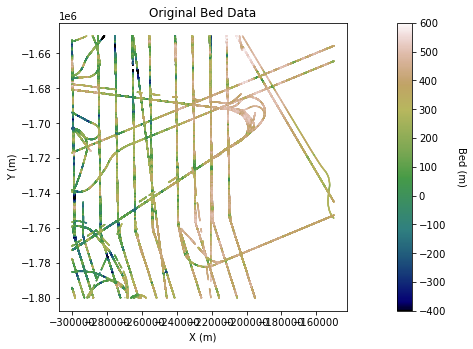

In [2]:
df_bed = pd.read_csv('Data/greenland_test_data.csv') # download data
df_bed = df_bed[df_bed["Bed"] <= 700]  # remove erroneously high values, presumably due to bad bed picks

# plot original data
im = plt.scatter(df_bed['X'],df_bed['Y'], c = df_bed['Bed'], vmin = -400, vmax = 600, marker=".", s = 0.5, 
                 cmap = 'gist_earth')       # scatter plot for location map
plt.title('Original Bed Data')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed (m)", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')
plt.show

## Grid and transform data, compute variogram parameters

In [3]:
# Grid data
res = 1000  # resolution
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res) # grid data
df_grid = df_grid[df_grid["Z"].isnull() == False]  # remove coordinates with NaNs
df_grid = df_grid.rename(columns = {"Z": "Bed"}) # rename column for consistency

df_grid['Nbed'], tvbed, tnsbed = geostats.nscore(df_grid,'Bed')  # normal score transformation

# compute experimental (isotropic) variogram
coords = df_grid[['X','Y']].values
values = df_grid['Nbed']

maxlag = 50000 # maximum range distance
n_lags = 70 #num of bins

V1 = skg.Variogram(coords, values, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

V1.model = 'exponential' # use exponential variogram model

## Initialize grid

Make list of grid cells that need to be simulated.

In [4]:
# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

## Sequential Gaussian simulation

Sequential Gaussian simulation (SGS) uses kriging to sequentially estimate the kriging mean and variance at each grid cell. This mean and variance define a Gaussian probability distribution from which a random value sampled in order to simulate a grid cell.

<img src ="Images/SGS_cartoon-01.jpg" width="700">

We have two versions of sequential Gaussian simulation, skrige_SGS and okrige_SGS, which use simple and ordinary kriging, respectively. In this example we use okrige_SGS.

In [5]:
# set variogram parameters
azimuth = 0
nugget = V1.parameters[2]
# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
vario = [azimuth, nugget, major_range, minor_range, sill] # save variogram parameters as a list

k = 48 # number of neighboring data points used to estimate a given point 
rad = 50000 # 50 km search radius

sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 

100%|████████████████████████████████████| 22500/22500 [02:38<00:00, 141.68it/s]


In [6]:
# reverse normal score transformation
df_sim= pd.DataFrame(sim, columns = ['sim'])

# transformation parameters
vr = tvbed; vrg = tnsbed; ltail = 1; utail = 1; zmin = -4; zmax = 4; ltpar = -1500; utpar = 1500

# transformation
sim_trans = geostats.backtr(df_sim,'sim',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar)

(-307450.0, -143550.0, -1807450.0, -1643550.0)

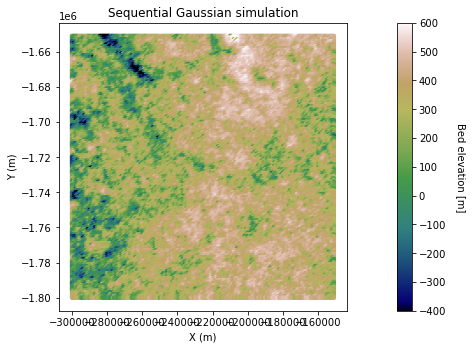

In [7]:
# plot simulation

im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sim_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('Sequential Gaussian simulation')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0) # adjust the plot size
plt.axis('scaled')

<Figure size 432x288 with 0 Axes>

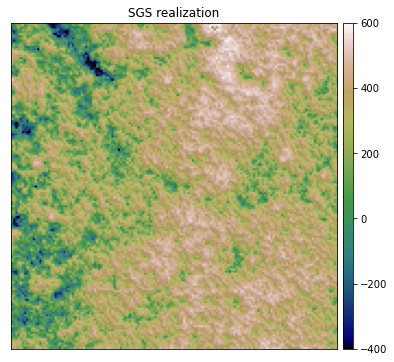

In [8]:
# make hillshade plot for visualizing

# reshape grid
ylen = (ymax + res - ymin)/res
xlen = (xmax + res - xmin)/res
elevation =  np.reshape(sim_trans, (int(ylen), int(xlen)))
elevation = elevation 

hillshade = es.hillshade(elevation, azimuth = 210, altitude = 10) # hillshade

fig = plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    elevation,
    ax=ax,
    cmap="gist_earth",
    title="SGS realization",
    vmin = -400, vmax = 600,
)
ax.imshow(hillshade, cmap="Greys", alpha=0.1)
plt.show()

SGS can be used to simulate multiple realizations for quantifying uncertainty. Let's generate a couple more realizations.

In [9]:
# simulate multiple random realizations

# simulation 2
sim2 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
df_sim= pd.DataFrame(sim2, columns = ['sim2'])
sim2_trans = geostats.backtr(df_sim,'sim2',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar) # back transformation

# simulation 3
sim3 = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad) 
df_sim= pd.DataFrame(sim2, columns = ['sim3'])
sim3_trans = geostats.backtr(df_sim,'sim3',vr,vrg,zmin,zmax,ltail,ltpar,utail,utpar) # back transformation

100%|████████████████████████████████████| 22500/22500 [02:49<00:00, 132.65it/s]


(-307450.0, -143550.0, -1807450.0, -1643550.0)

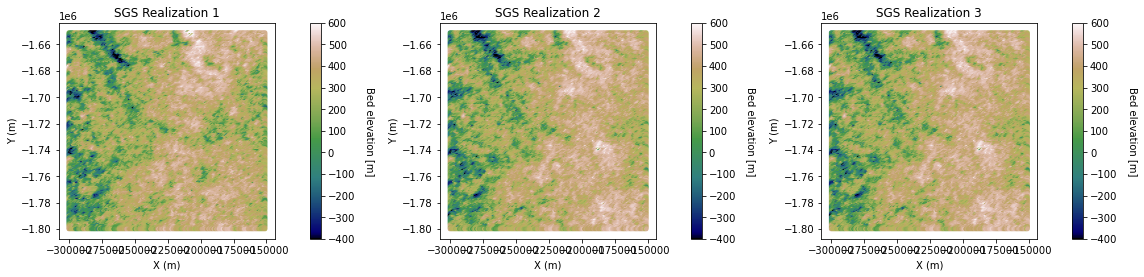

In [10]:
# plot simulations
plt.subplot(131) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sim_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('SGS Realization 1')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.axis('scaled')


plt.subplot(132) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sim2_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('SGS Realization 2')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.axis('scaled')


plt.subplot(133) 
im = plt.scatter(Pred_grid_xy[:,0],Pred_grid_xy[:,1], c = sim3_trans, vmin = -400, vmax = 600, marker=".", s = 50,
                cmap = 'gist_earth')       # scatter plot for location map
plt.title('SGS Realization 3')                                    # add plot title
plt.xlabel('X (m)'); plt.ylabel('Y (m)')                          # set axis labels
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-400, 600, 11)) # add vertical color bar
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=20)      # add labels to the color bar
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=.75) # adjust the plot size
plt.axis('scaled')

You can see that they all look a bit different from each other.

## SGS Roughness

The topography generated using SGS is much rougher than the kriging examples. Let's check the variograms to see if the roughness statistics of the data are reproduced.

In [11]:
# compute SGS variogram

# downsample random indices to speed this up
rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),5000) # generate random numbers to keep

coords_s = Pred_grid_xy[rand_indices]
values_s = sim[rand_indices]  # notice that we're using the simulated topography values prior to back transformation 
#because the experimental variogram was computed on normalized data

VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags, 
                   maxlag = maxlag, normalize=False)

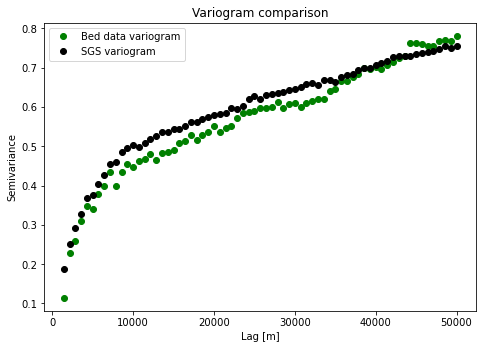

In [12]:
# plot variogram

# extract variogram values

# experimental variogram (from beginning of script)
xe = V1.bins
ye = V1.experimental

# simple kriging variogram
xs = VS.bins
ys = VS.experimental

fig = plt.figure()
plt.plot(xe,ye,'og', label = 'Bed data variogram')
plt.plot(xs,ys,'ok', label = 'SGS variogram')
plt.title('Variogram comparison')
plt.xlabel('Lag [m]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1) # adjust the plot size
plt.legend(loc='upper left')

We can see that the variograms are very similar. This means that SGS is reproducing the spatial statistics of observations.